# Stationarity and Transformations: Preparing Data for ARIMA

## Learning Objectives
By the end of this notebook, you will be able to:
1. Understand what stationarity means in plain language
2. Identify stationary vs non-stationary data visually
3. Use differencing to remove trends
4. Use log transforms to stabilize variance
5. Understand when and why to make data stationary


## Introduction: Why Stationarity Matters

**⚠️ CRITICAL CONCEPT: Stationarity is essential for ARIMA models!**

Before we can build ARIMA models, we need to understand stationarity. This might sound complicated, but it's actually a simple concept.

**What is stationarity?** A stationary time series is "stable" - it doesn't drift up or down, and its variability stays roughly the same over time.

**Why it matters:** ARIMA models assume your data is stationary. If your data has trends or changing variability, ARIMA won't work well until you fix it.

**Think of it like this:** 
- **Non-stationary:** A car driving up a hill (trend) or a car with increasing speed (changing variance)
- **Stationary:** A car idling in a parking lot (stable, no drift)

**Real-World Example:** Company revenue growing year over year is non-stationary (has a trend). But the month-to-month change in revenue might be stationary (the changes are stable).

**Think About It:** Can you think of a time series that would be stationary? (Hint: Think about things that stay relatively constant over time)


In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

# Set plotting style
plt.style.use('default')

print("Libraries imported successfully")


Libraries imported successfully


In [14]:
# Load and prepare the data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)

print("✅ Data loaded successfully")
print(f"Date range: {data.index.min()} to {data.index.max()}")


✅ Data loaded successfully
Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00


## Section 1: Understanding Stationarity

### What Makes Data Stationary?

A stationary time series has three key properties:

1. **Constant Mean:** The average value doesn't change over time
   - **Non-stationary example:** Sales growing from $1000 to $5000 (mean is increasing)
   - **Stationary example:** Temperature fluctuations around 70°F (mean stays at 70°F)

2. **Constant Variance:** The amount of variation stays the same
   - **Non-stationary example:** Sales vary by $100 early on, but by $500 later (variance increasing)
   - **Stationary example:** Daily temperature varies by ±5°F consistently (variance stays the same)

3. **No Trends or Seasonality:** No long-term patterns
   - **Non-stationary example:** Upward trend or repeating seasonal patterns
   - **Stationary example:** Random fluctuations around a constant level

**Think of it like this:** Stationary data is like a calm lake - it might have ripples (noise), but the water level stays the same. Non-stationary data is like a rising tide - the level keeps changing.


### Visual Check: Is Our Data Stationary?

Let's look at our airline passenger data and see if it's stationary:


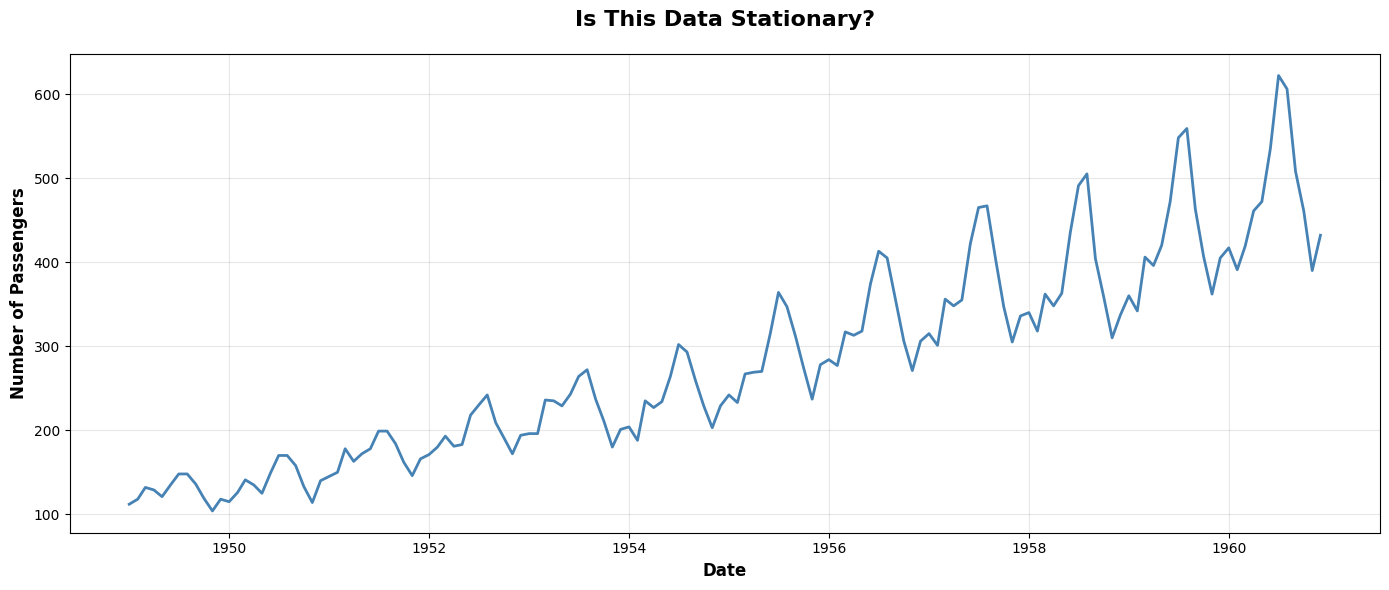


🔍 Visual Analysis Questions:
1. Is the mean constant? (Is the data staying at the same level?)
2. Is the variance constant? (Are the fluctuations the same size?)
3. Is there a trend? (Is it going up or down?)

💡 What do you think? Is this stationary?


In [15]:
# Plot the original data
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['#Passengers'], linewidth=2, color='steelblue')
plt.title('Is This Data Stationary?', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Number of Passengers', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Visual Analysis Questions:")
print("1. Is the mean constant? (Is the data staying at the same level?)")
print("2. Is the variance constant? (Are the fluctuations the same size?)")
print("3. Is there a trend? (Is it going up or down?)")
print("\n💡 What do you think? Is this stationary?")


### Analysis: Our Data is NOT Stationary

Looking at the plot, we can see:

1. **❌ Non-constant mean:** The data is clearly going up over time (upward trend)
2. **❌ Non-constant variance:** The fluctuations are getting larger over time (variance increasing)
3. **❌ Has trend:** Clear upward growth pattern
4. **❌ Has seasonality:** Repeating yearly patterns

**Conclusion:** This data is **non-stationary**. We need to make it stationary before using ARIMA!

**Why this matters:** ARIMA models assume stationary data. If we use non-stationary data, the model won't work properly. It's like trying to use a ruler designed for flat surfaces on a curved surface - it won't give accurate measurements!


## Section 2: Making Data Stationary - Differencing

### What is Differencing?

**Differencing** means calculating the change from one period to the next. Instead of looking at the actual values, we look at how much they changed.

**Simple example:**
- Original: [100, 120, 140, 160]
- Differences: [20, 20, 20] (each value minus the previous)

**Why it works:** If data has a trend (going up), the differences remove that trend. The differences show the "change" rather than the "level."

**Think of it like this:** Instead of tracking your bank account balance (which goes up), track how much it changes each month (which might be stable).

### Applying Differencing

Let's apply differencing to our data:


In [16]:
# Calculate the first difference
# This subtracts each value from the previous value
data['Passenger_Diff'] = data['#Passengers'].diff()

# Remove the first row (it will be NaN because there's no previous value)
data_diff = data['Passenger_Diff'].dropna()

print("✅ Differencing completed")
print(f"\nOriginal data (first 5 values): {data['#Passengers'].head().values}")
print(f"Differenced data (first 5 values): {data_diff.head().values}")
print(f"\n💡 Notice: The differenced values show the CHANGE, not the level")


✅ Differencing completed

Original data (first 5 values): [112 118 132 129 121]
Differenced data (first 5 values): [ 6. 14. -3. -8. 14.]

💡 Notice: The differenced values show the CHANGE, not the level


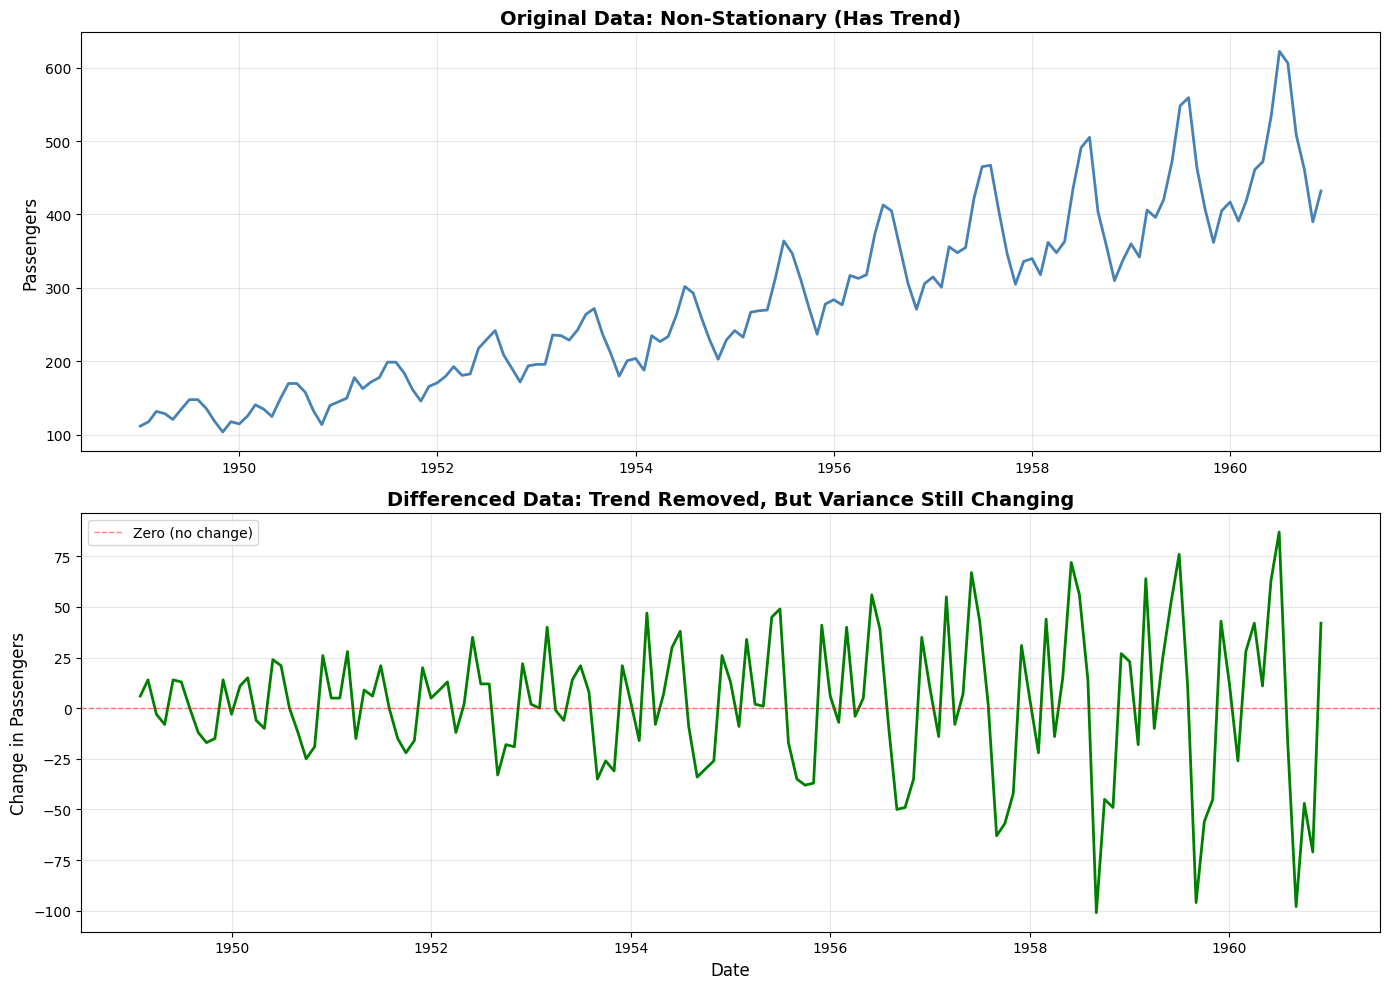


📊 Comparison:
✅ ORIGINAL: Clear upward trend (non-stationary)
✅ DIFFERENCED: Trend removed Mean is now around zero
⚠️  BUT: Variance is still increasing (fluctuations getting bigger)

💡 We removed the trend, but we still need to fix the variance


In [17]:
# Visualize original vs differenced data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Original data
ax1.plot(data.index, data['#Passengers'], linewidth=2, color='steelblue')
ax1.set_title('Original Data: Non-Stationary (Has Trend)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Passengers', fontsize=12)
ax1.grid(True, alpha=0.3)

# Differenced data
ax2.plot(data_diff.index, data_diff.values, linewidth=2, color='green')
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero (no change)')
ax2.set_title('Differenced Data: Trend Removed, But Variance Still Changing', 
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Change in Passengers', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print("\n📊 Comparison:")
print("✅ ORIGINAL: Clear upward trend (non-stationary)")
print("✅ DIFFERENCED: Trend removed Mean is now around zero")
print("⚠️  BUT: Variance is still increasing (fluctuations getting bigger)")
print("\n💡 We removed the trend, but we still need to fix the variance")


## Section 3: Stabilizing Variance - Log Transform

### Why We Need Log Transform

After differencing, we removed the trend. But we still have a problem: the variance is increasing over time (fluctuations are getting bigger).

**The solution:** Use a log transform to stabilize the variance.

**What log transform does:** It converts multiplicative patterns to additive patterns. Instead of fluctuations growing as a percentage, they become fixed amounts.

**Think of it like this:**
- **Before log:** Sales vary by 20% (so $1000 varies by $200, but $5000 varies by $1000 - variance grows!)
- **After log:** Sales vary by a fixed amount (variance stays the same)

### Applying Log Transform

Let's apply log transform to our data:


In [18]:
# Apply natural log transform
# This stabilizes the variance
data['Passenger_Log'] = np.log(data['#Passengers'])

print("✅ Log transform completed")
print(f"\nOriginal (first 5): {data['#Passengers'].head().values}")
print(f"Log transformed (first 5): {data['Passenger_Log'].head().values}")
print(f"\n💡 The log transform compresses large values more than small values")
print("   This makes the variance more consistent across the time series")


✅ Log transform completed

Original (first 5): [112 118 132 129 121]
Log transformed (first 5): [4.71849887 4.77068462 4.88280192 4.8598124  4.79579055]

💡 The log transform compresses large values more than small values
   This makes the variance more consistent across the time series


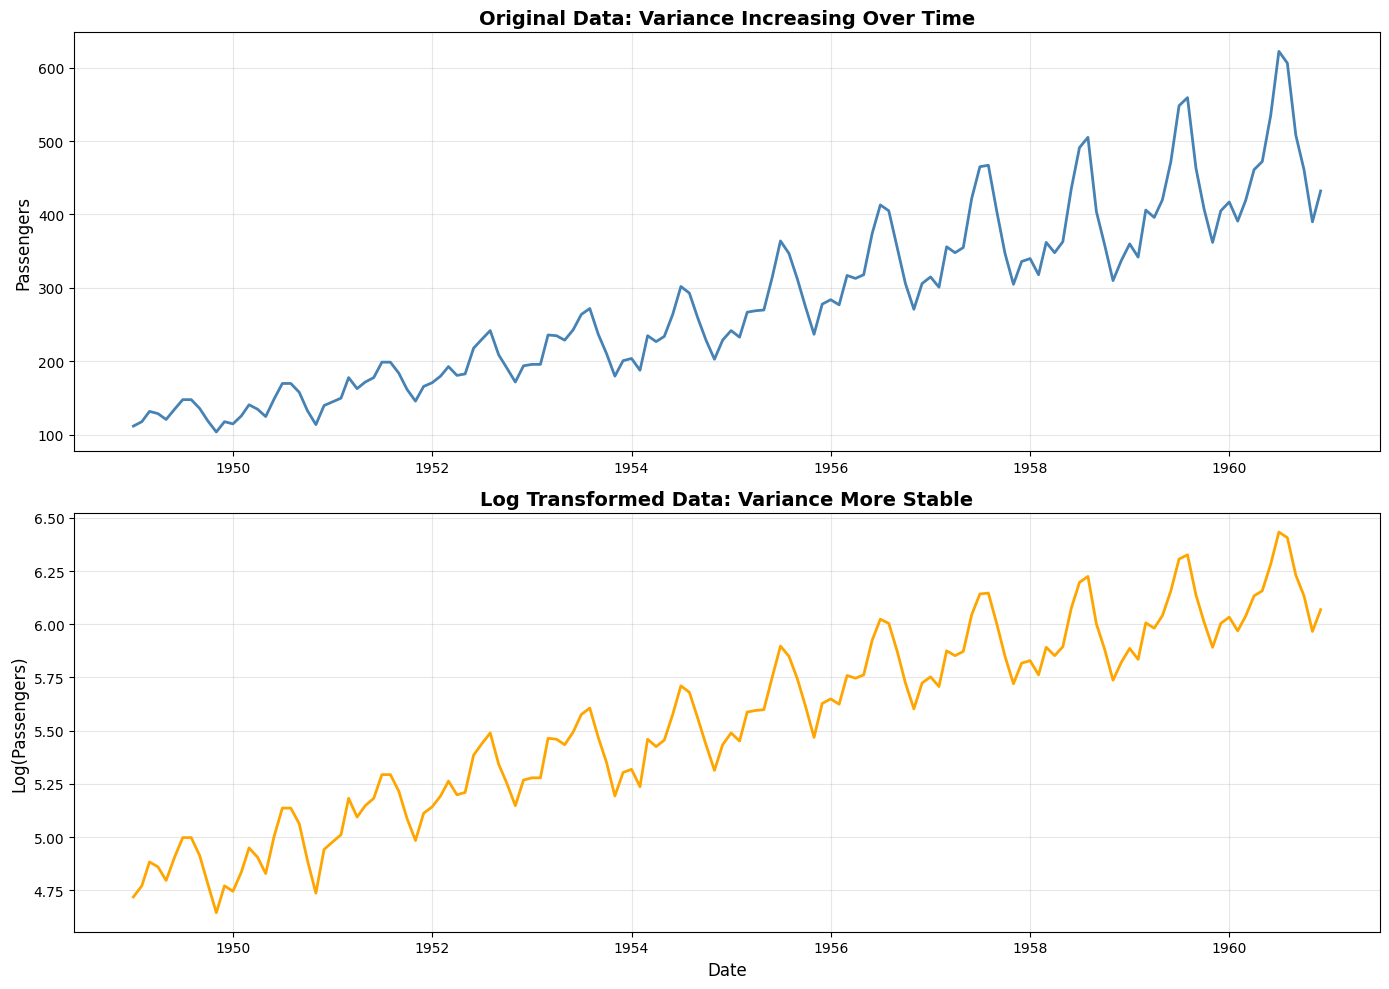


📊 Comparison:
✅ ORIGINAL: Fluctuations getting larger over time
✅ LOG TRANSFORMED: Fluctuations more consistent in size
⚠️  BUT: Still has a trend (going up)

💡 We stabilized the variance, but we still need to remove the trend


In [19]:
# Visualize original vs log transformed
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Original data
ax1.plot(data.index, data['#Passengers'], linewidth=2, color='steelblue')
ax1.set_title('Original Data: Variance Increasing Over Time', fontsize=14, fontweight='bold')
ax1.set_ylabel('Passengers', fontsize=12)
ax1.grid(True, alpha=0.3)

# Log transformed data
ax2.plot(data.index, data['Passenger_Log'], linewidth=2, color='orange')
ax2.set_title('Log Transformed Data: Variance More Stable', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Log(Passengers)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Comparison:")
print("✅ ORIGINAL: Fluctuations getting larger over time")
print("✅ LOG TRANSFORMED: Fluctuations more consistent in size")
print("⚠️  BUT: Still has a trend (going up)")
print("\n💡 We stabilized the variance, but we still need to remove the trend")


## Section 4: Combining Log and Differencing

### The Complete Solution

To make our data fully stationary, we need to:
1. **Apply log transform** (stabilizes variance)
2. **Then apply differencing** (removes trend)

This combination handles both problems!

### Applying Both Transformations

Let's apply both transformations in sequence:


In [20]:
# Step 1: Log transform (already done)
# Step 2: Difference the log-transformed data
data['Passenger_Diff_Log'] = data['Passenger_Log'].diff()

# Remove NaN values
data_stationary = data['Passenger_Diff_Log'].dropna()

print("✅ Combined transformation completed")
print(f"\nProcess:")
print("1. Applied log transform (stabilized variance)")
print("2. Applied differencing (removed trend)")
print(f"\nResult: {len(data_stationary)} values (first value removed due to differencing)")


✅ Combined transformation completed

Process:
1. Applied log transform (stabilized variance)
2. Applied differencing (removed trend)

Result: 143 values (first value removed due to differencing)


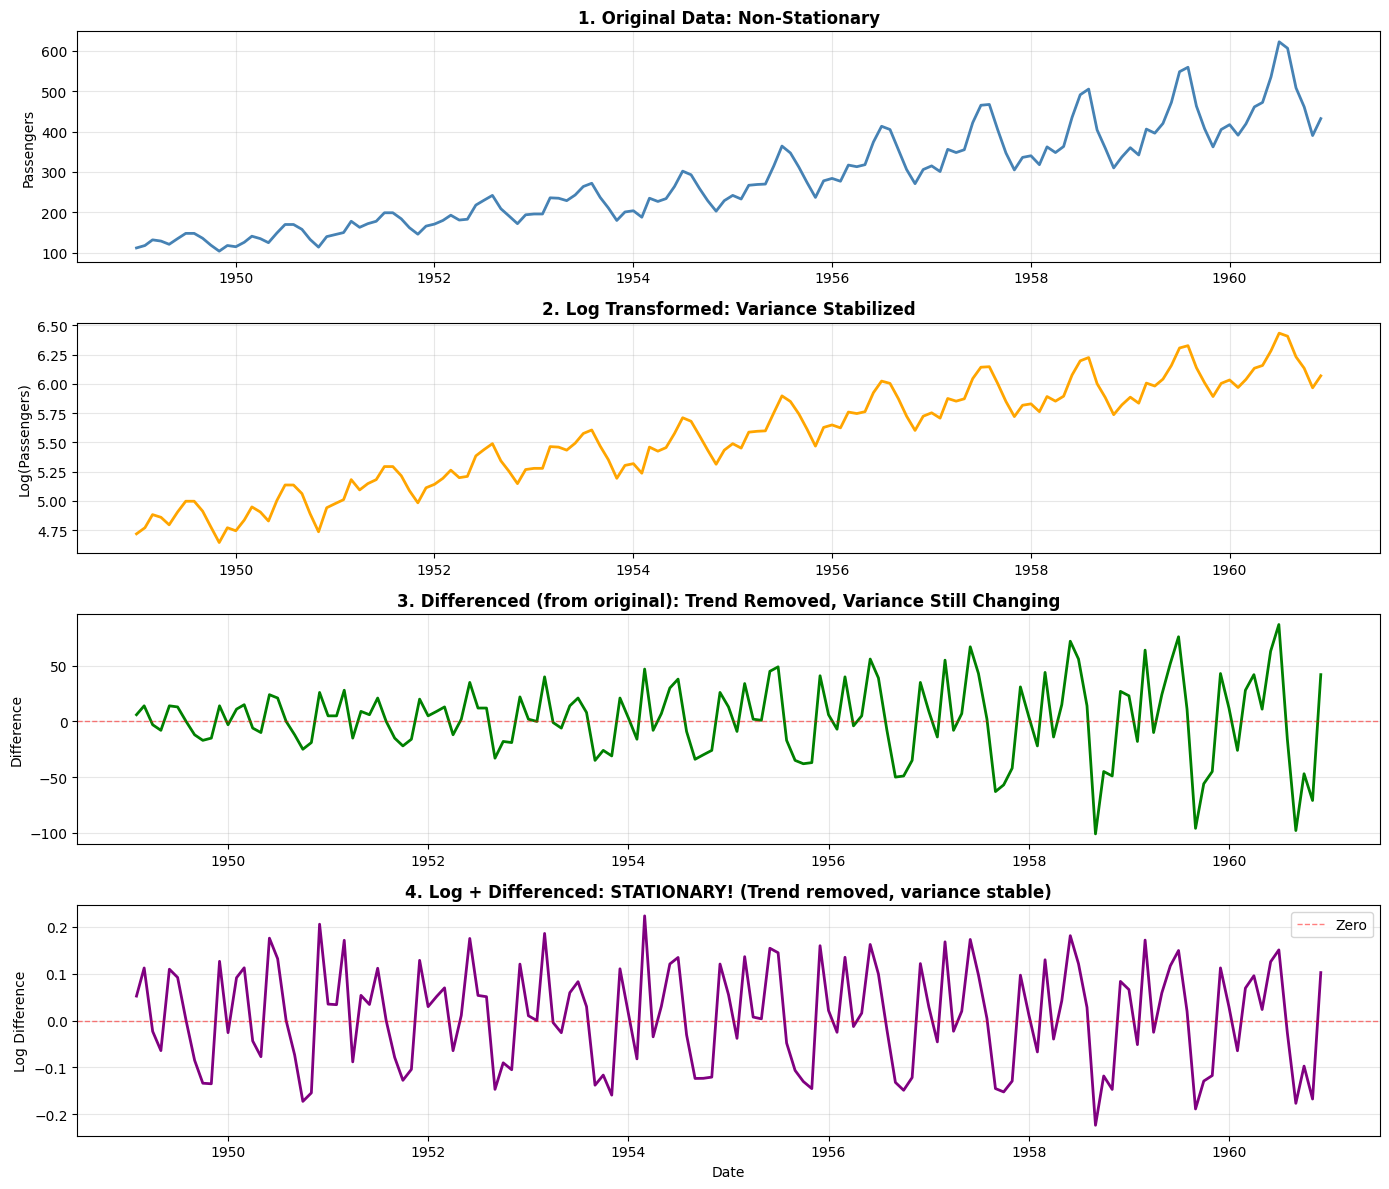


📊 Final Result:
✅ Mean is constant (oscillating around zero)
✅ Variance is constant (fluctuations are consistent size)
✅ No trend (not going up or down)

💡 This data is now STATIONARY and ready for ARIMA


In [21]:
# Visualize the transformation process
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Original
axes[0].plot(data.index, data['#Passengers'], linewidth=2, color='steelblue')
axes[0].set_title('1. Original Data: Non-Stationary', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Passengers', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Log transformed
axes[1].plot(data.index, data['Passenger_Log'], linewidth=2, color='orange')
axes[1].set_title('2. Log Transformed: Variance Stabilized', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Log(Passengers)', fontsize=10)
axes[1].grid(True, alpha=0.3)

# Differenced (from original)
axes[2].plot(data_diff.index, data_diff.values, linewidth=2, color='green')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[2].set_title('3. Differenced (from original): Trend Removed, Variance Still Changing', 
                  fontsize=12, fontweight='bold')
axes[2].set_ylabel('Difference', fontsize=10)
axes[2].grid(True, alpha=0.3)

# Log + Differenced (FINAL - should be stationary)
axes[3].plot(data_stationary.index, data_stationary.values, linewidth=2, color='purple')
axes[3].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Zero')
axes[3].set_title('4. Log + Differenced: STATIONARY! (Trend removed, variance stable)', 
                  fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=10)
axes[3].set_ylabel('Log Difference', fontsize=10)
axes[3].grid(True, alpha=0.3)
axes[3].legend()

plt.tight_layout()
plt.show()

print("\n📊 Final Result:")
print("✅ Mean is constant (oscillating around zero)")
print("✅ Variance is constant (fluctuations are consistent size)")
print("✅ No trend (not going up or down)")
print("\n💡 This data is now STATIONARY and ready for ARIMA")


## Section 5: Box-Cox Transform (Advanced Option)

### What is Box-Cox Transform?

**Box-Cox transform** is a more flexible version of the log transform. It automatically finds the best transformation to stabilize variance.

**How it works:** It tries different transformations and picks the one that makes the data most "normal" (like a bell curve).

**When to use:** When you're not sure if log transform is the right choice, Box-Cox can find the optimal transformation automatically.

**Note:** For most practical purposes, log transform works well. Box-Cox is useful when you want the "best" transformation automatically.

### Applying Box-Cox Transform

Let's see how Box-Cox compares to log transform:


In [22]:
# Apply Box-Cox transform
# This automatically finds the best transformation
data['Passenger_BoxCox'], lambda_param = boxcox(data['#Passengers'])

print("✅ Box-Cox transform completed")
print(f"\nOptimal lambda parameter: {lambda_param:.4f}")
print(f"💡 Lambda near 0 = similar to log transform")
print(f"   Lambda = 1 = no transform needed")
print(f"   Lambda = 0.5 = similar to square root transform")
print(f"\nOur lambda ({lambda_param:.4f}) is close to 0, so log transform was a good choice")


✅ Box-Cox transform completed

Optimal lambda parameter: 0.1480
💡 Lambda near 0 = similar to log transform
   Lambda = 1 = no transform needed
   Lambda = 0.5 = similar to square root transform

Our lambda (0.1480) is close to 0, so log transform was a good choice


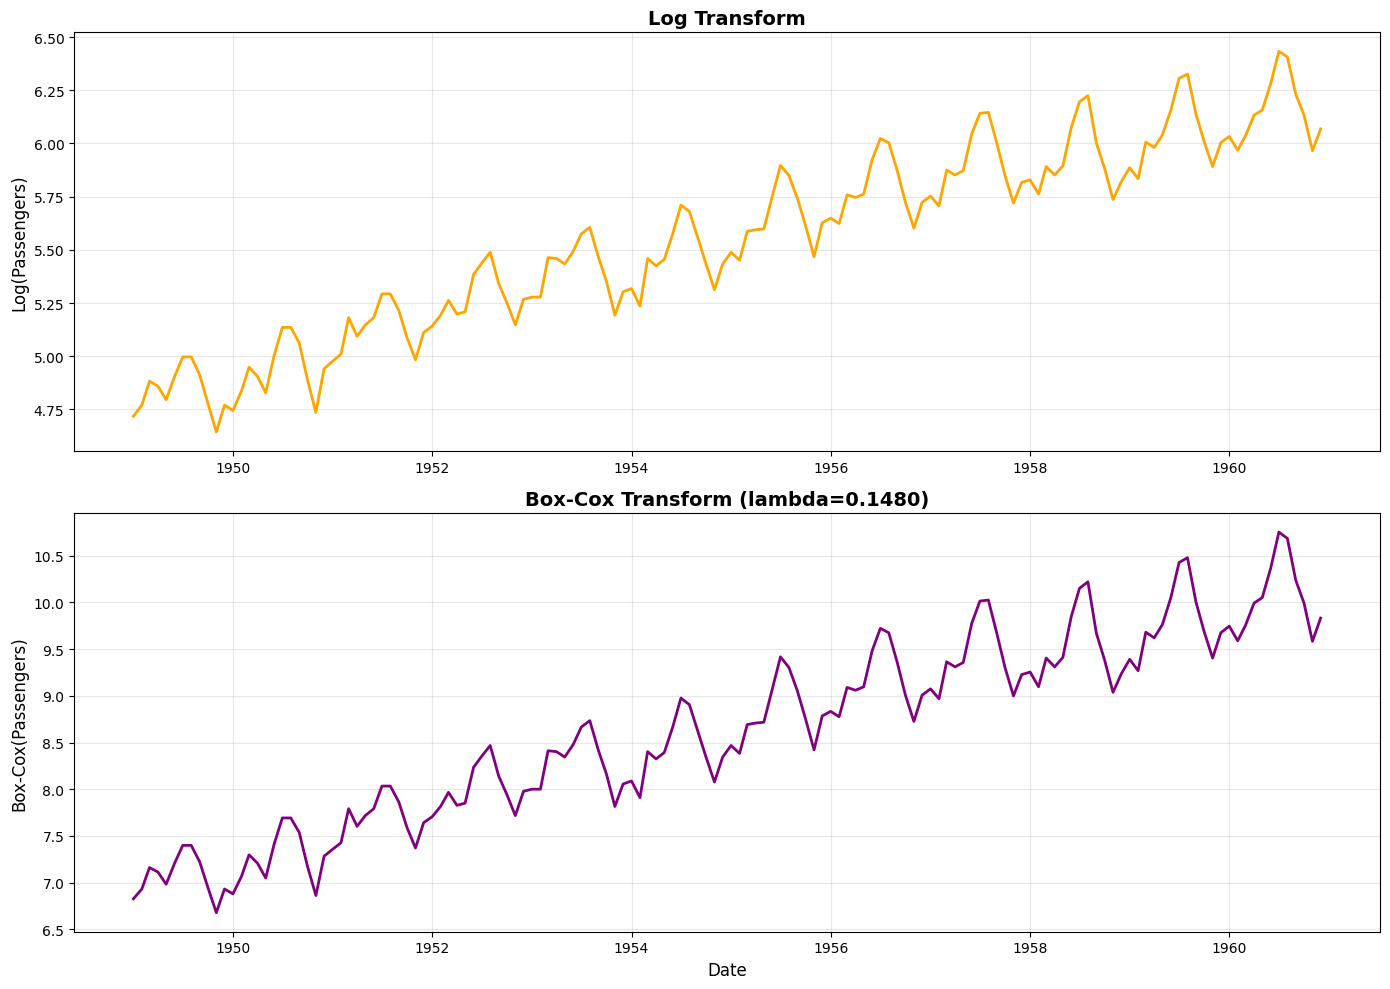


📊 Comparison:
✅ Both transforms look very similar (lambda is close to 0)
✅ For this data, log transform is sufficient
💡 Box-Cox is useful when you're not sure which transform to use


In [23]:
# Compare log vs Box-Cox
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Log transform
ax1.plot(data.index, data['Passenger_Log'], linewidth=2, color='orange')
ax1.set_title(f'Log Transform', fontsize=14, fontweight='bold')
ax1.set_ylabel('Log(Passengers)', fontsize=12)
ax1.grid(True, alpha=0.3)

# Box-Cox transform
ax2.plot(data.index, data['Passenger_BoxCox'], linewidth=2, color='purple')
ax2.set_title(f'Box-Cox Transform (lambda={lambda_param:.4f})', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Box-Cox(Passengers)', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Comparison:")
print("✅ Both transforms look very similar (lambda is close to 0)")
print("✅ For this data, log transform is sufficient")
print("💡 Box-Cox is useful when you're not sure which transform to use")


## Section 6: Statistical Test for Stationarity (ADF Test)

### What is the ADF Test?

The **Augmented Dickey-Fuller (ADF) test** is a statistical test that tells us if data is stationary.

**How to interpret it:**
- **P-value < 0.05:** Data is likely stationary (reject the null hypothesis)
- **P-value > 0.05:** Data is likely non-stationary (can't reject the null hypothesis)

**Think of it like this:** It's a "second opinion" to confirm what we see visually.

### Testing Our Transformed Data

Let's test if our log+differenced data is actually stationary:


In [24]:
# ADF test on the stationary data
def interpret_adf_test(series, name="Series"):
    """Run ADF test and interpret results in plain language"""
    result = adfuller(series.dropna())
    
    print(f"\n{'='*60}")
    print(f"ADF Test Results: {name}")
    print(f"{'='*60}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"P-Value: {result[1]:.4f}")
    print(f"\nCritical Values (thresholds):")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")
    
    print(f"\n💡 Interpretation:")
    if result[1] <= 0.05:
        print(f"  ✅ P-value ({result[1]:.4f}) ≤ 0.05")
        print(f"  ✅ Data appears to be STATIONARY")
        print(f"  ✅ Good for ARIMA modeling")
    else:
        print(f"  ⚠️  P-value ({result[1]:.4f}) > 0.05")
        print(f"  ⚠️  Data may still be NON-STATIONARY")
        print(f"  ⚠️  May need additional transformations")
    
    return result

# Test original data
print("Testing ORIGINAL data:")
adf_original = interpret_adf_test(data['#Passengers'], "Original Data")

# Test transformed data
print("\n\nTesting TRANSFORMED data (log + differenced):")
adf_transformed = interpret_adf_test(data_stationary, "Log + Differenced Data")


Testing ORIGINAL data:

ADF Test Results: Original Data
ADF Statistic: 0.8154
P-Value: 0.9919

Critical Values (thresholds):
  1%: -3.4817
  5%: -2.8840
  10%: -2.5788

💡 Interpretation:
  ⚠️  P-value (0.9919) > 0.05
  ⚠️  Data may still be NON-STATIONARY
  ⚠️  May need additional transformations


Testing TRANSFORMED data (log + differenced):

ADF Test Results: Log + Differenced Data
ADF Statistic: -2.7171
P-Value: 0.0711

Critical Values (thresholds):
  1%: -3.4825
  5%: -2.8844
  10%: -2.5790

💡 Interpretation:
  ⚠️  P-value (0.0711) > 0.05
  ⚠️  Data may still be NON-STATIONARY
  ⚠️  May need additional transformations


## Section 7: When to Use Which Transformation

### Decision Guide

**1. Data has trend but stable variance:**
   - Use: **Differencing only**
   - Example: Data going up, but fluctuations stay same size

**2. Data has stable trend but increasing variance:**
   - Use: **Log transform only**
   - Example: Data going up steadily, but fluctuations getting bigger

**3. Data has both trend AND increasing variance (most common):**
   - Use: **Log transform + Differencing**
   - Example: Our airline data (growing AND fluctuations getting bigger)

**4. Not sure which transform to use:**
   - Use: **Box-Cox transform** (finds optimal automatically)
   - Then apply differencing if needed

### Visual Check First!

**Always check visually before using statistical tests:**
1. Plot the original data
2. Look for trends and changing variance
3. Apply appropriate transformations
4. Plot again to verify
5. Use ADF test as confirmation

**Think About It:** Why do you think visual checks should come before statistical tests?


## Summary: Key Takeaways

This notebook covered stationarity and transformations:

### What We Learned

1. **Stationarity Definition:**
   - Constant mean (no drift)
   - Constant variance (consistent fluctuations)
   - No trends or seasonality
   - Required for ARIMA models

2. **Making Data Stationary:**
   - **Differencing:** Removes trends (look at changes, not levels)
   - **Log Transform:** Stabilizes variance (converts percentages to fixed amounts)
   - **Combination:** Log + Differencing handles both problems

3. **Box-Cox Transform:**
   - Automatic variance stabilization
   - Finds optimal transformation
   - Useful when unsure which transform to use

4. **ADF Test:**
   - Statistical confirmation of stationarity
   - P-value < 0.05 = likely stationary
   - Use as confirmation, not replacement for visual checks

### Key Insights

- **Visual first:** Always plot data before and after transformations
- **ARIMA requires stationarity:** Non-stationary data won't work with ARIMA
- **Common pattern:** Most business data needs log + differencing
- **Test to confirm:** Use ADF test to verify stationarity

### Why This Matters

Understanding stationarity helps you:
- Prepare data correctly for ARIMA
- Choose the right transformations
- Build better forecasting models
- Avoid model failures

